In [298]:
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import orientationpy
import tifffile
import skimage
from scipy import signal, ndimage
from scipy import ndimage as ndi
from skimage.color import label2rgb

In [299]:
def find_centers(nuclei):

    labs_nuc = skimage.measure.label(nuclei)
    props = skimage.measure.regionprops(labs_nuc)
    lbls = np.unique(labs_nuc)[:-1]
    centers = []
    for lbl in lbls:
        centers = np.append(centers,props[lbl]['centroid'])
    centers = np.reshape(centers,(-1,2))

    return centers

The Y and X dimensions of the image: (1024, 1024)


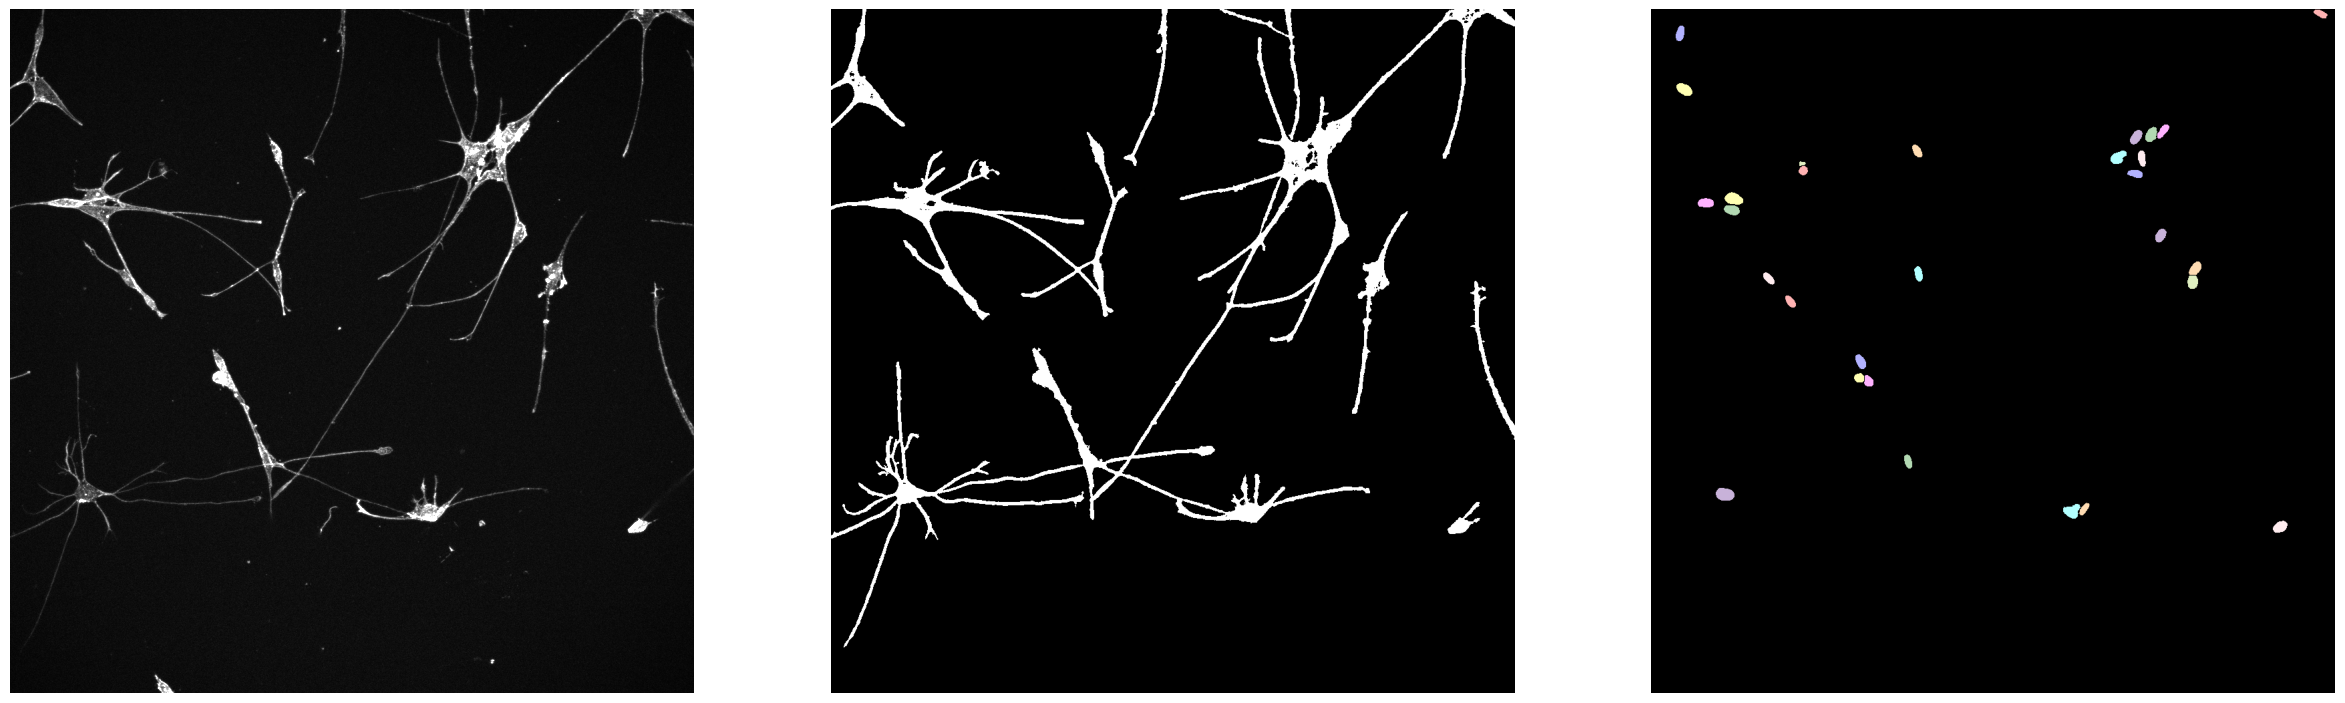

In [300]:
# Load the greyscale image
folder_path = '/Volumes/imganfac/neurogenomics/kalebic/Stefania/EC_007_split/'
cells = tifffile.imread(folder_path+'segmentation_cell/segmentation_fullcells.tif')
nuclei = 255-tifffile.imread(folder_path+'segmentation_nuclei.tif')
image = tifffile.imread(folder_path+'AVG_C2-RO06 2D.lif - E-GSC ro06 nes488_phal647_sox2555_dapi007.tif')
print(f"The Y and X dimensions of the image: {image.shape}")


large_cells = skimage.morphology.area_opening(cells, area_threshold=500)

labs_nuc = skimage.measure.label(nuclei)


fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(image, vmin=0, vmax=20055, cmap="gray")
ax[0].set_axis_off()

ax[1].imshow(large_cells, cmap="gray")
ax[1].set_axis_off()

color1 = label2rgb(labs_nuc, image=nuclei, bg_label=0)
ax[2].imshow(color1)
ax[2].set_axis_off()


plt.show()

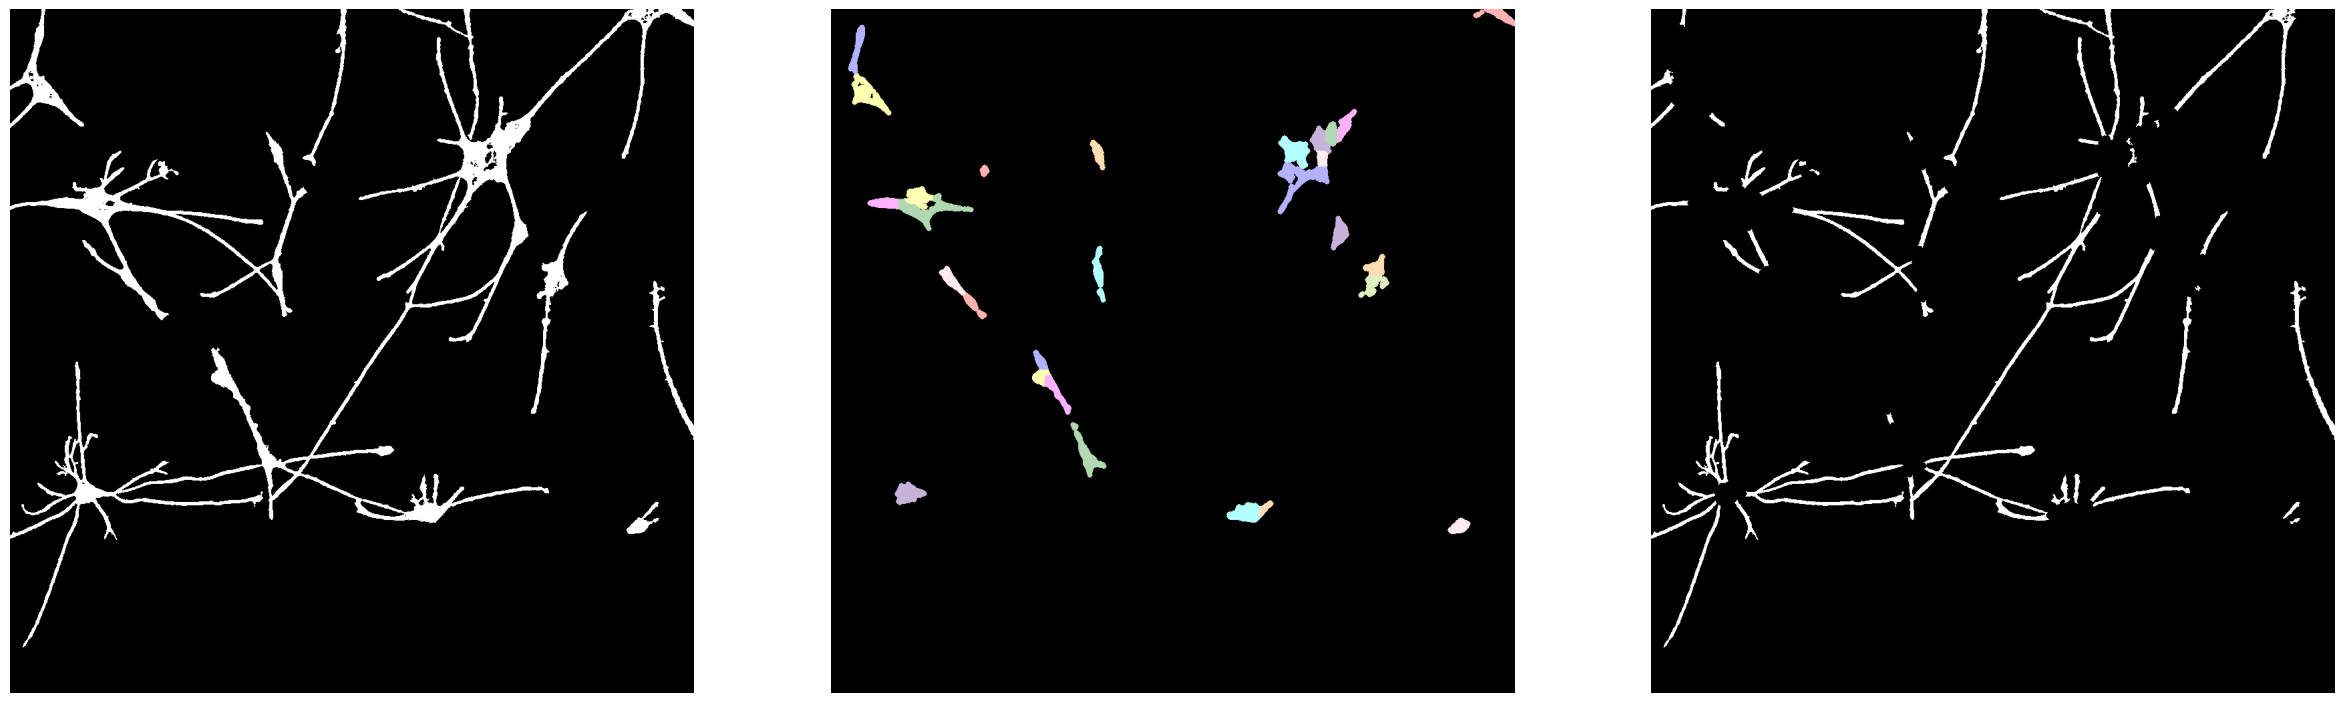

In [301]:
footprint = skimage.morphology.disk(4)
cell_bodies = skimage.morphology.binary_opening(large_cells, footprint=footprint)
distance = ndi.distance_transform_edt(cell_bodies)
labels_cells = skimage.segmentation.watershed(-distance, markers=labs_nuc, mask=cell_bodies )
cell_bodies = labels_cells>0
protrusions = np.logical_and(large_cells,np.logical_not(cell_bodies))
protrusions = skimage.morphology.area_opening(protrusions, area_threshold=30)

fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(large_cells, cmap="gray")
ax[0].set_axis_off()
color1 = label2rgb(labels_cells, image=cell_bodies, bg_label=0)
ax[1].imshow(color1)
ax[1].set_axis_off()
ax[2].imshow(protrusions, cmap="gray")
ax[2].set_axis_off()



0

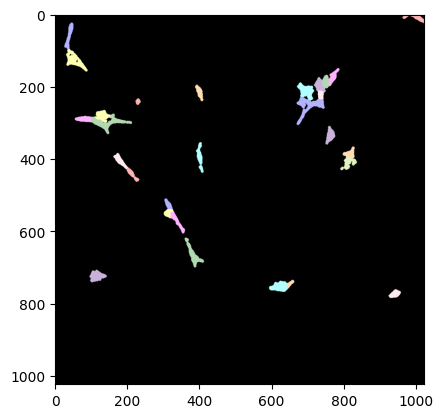

In [275]:
# # ind_center = 10
# # centers[ind_center]
# # markers = np.zeros_like(cell_bodies)
# # markers[centers[:,0].astype('int'),centers[:,1].astype('int')] = 1
# # #markers = skimage.filters.gaussian(markers, sigma=10)


# distance = ndi.distance_transform_edt(cell_bodies)
# labels_cells =skimage.segmentation.watershed(-distance, markers=labs_nuc, mask=cell_bodies )

# color1 = label2rgb(labels_cells, image=cell_bodies, bg_label=0)
# plt.imshow(color1)


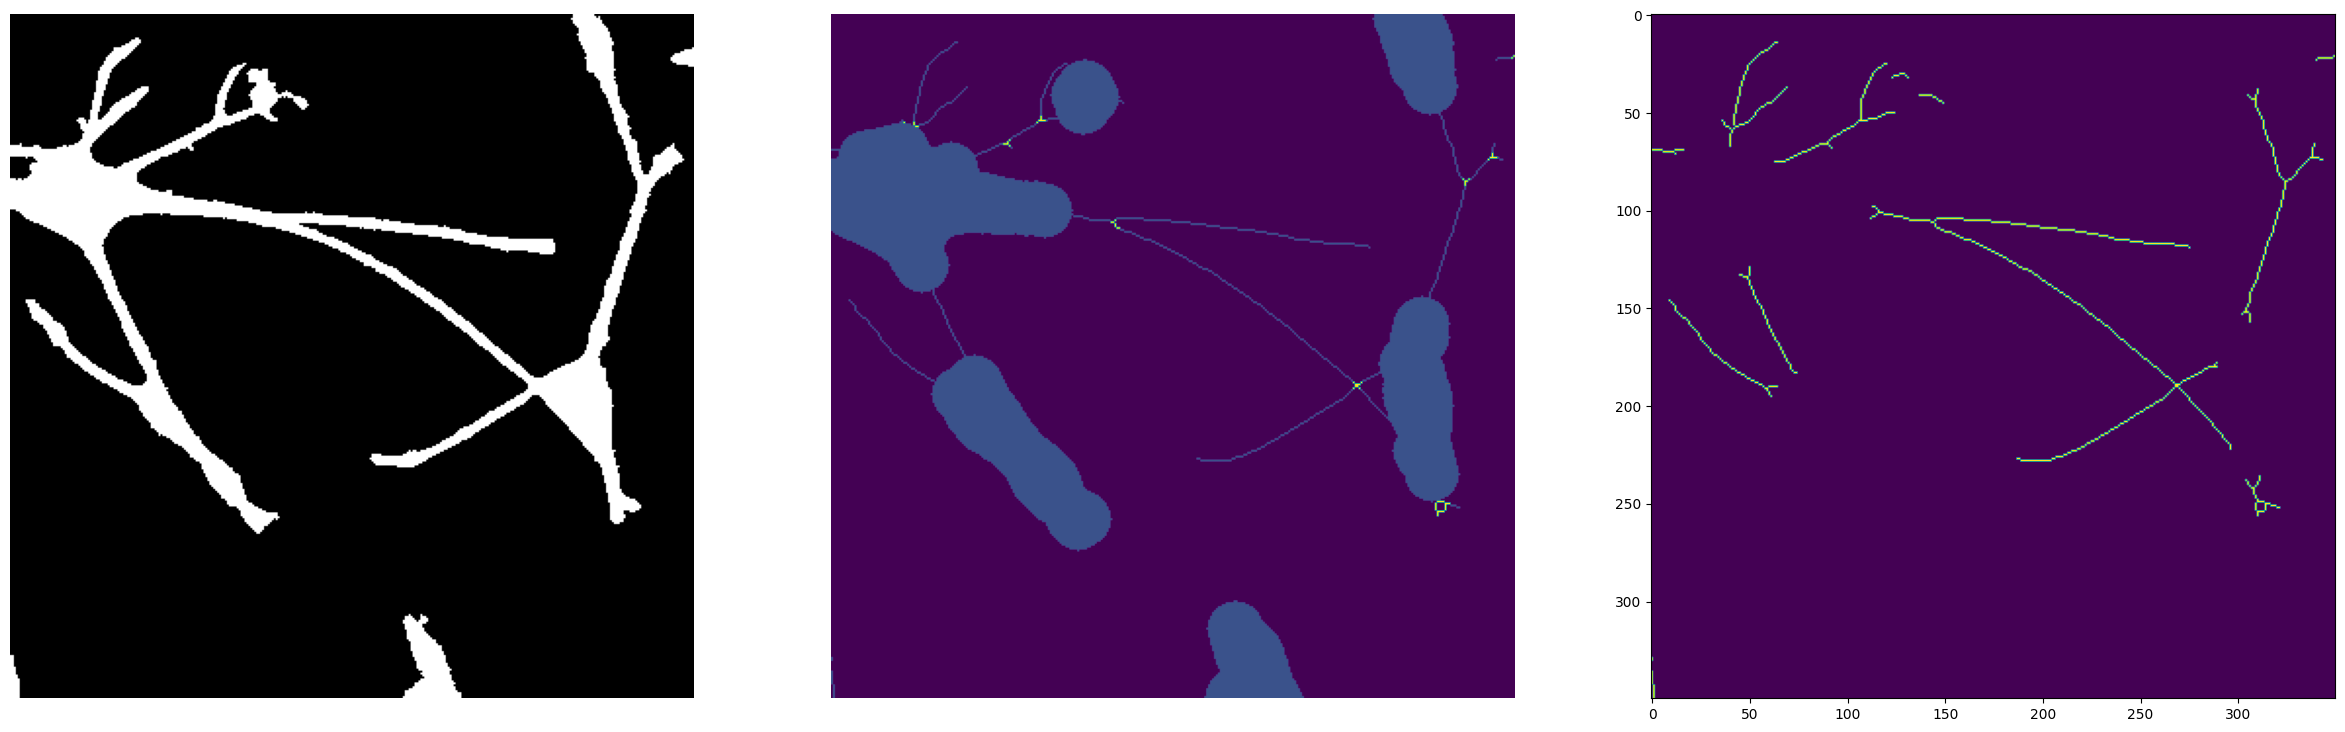

In [302]:
#start again here from cells
labs_cell = skimage.measure.label(cells)
large_cells = skimage.morphology.remove_small_objects(labs_cell, min_size=500)

large_cells = skimage.morphology.area_opening(cells, area_threshold=500)
large_cells = ndimage.binary_fill_holes(large_cells)
skeleton_cells = skimage.morphology.skeletonize(protrusions)




ind_cluster = 6
cluster = labs_cell==ind_cluster

# identify bifurcations and crossing points
crossings = signal.convolve2d(skeleton_cells, np.ones([3,3]), boundary='symm', mode='same')>3
logical_label_cells = labels_cells>0
logical_label_cells = ndimage.binary_fill_holes(logical_label_cells)
crossings = np.multiply(crossings,1-logical_label_cells)

crossings_large = signal.convolve2d(crossings, np.ones([3,3]), boundary='symm', mode='same')
crossing_points_all = np.logical_and(crossings_large>0,skeleton_cells)
dilated_cells = skimage.morphology.isotropic_dilation(logical_label_cells, 10)
crossing_points_all = np.logical_and(crossing_points_all,np.logical_not(dilated_cells))

fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(large_cells[200:550,100:450], cmap="gray")
ax[0].set_axis_off()
ax[1].imshow((dilated_cells+skeleton_cells+crossing_points_all*3)[200:550,100:450])
ax[1].set_axis_off()
ax[2].imshow(skeleton_cells[200:550,100:450])


In [243]:
def regionswithoverlap(protrusions, onecell_image):
    onecell_image_dil = skimage.morphology.isotropic_dilation(onecell_image, 10)
    labs_protrusions = skimage.measure.label(protrusions)
    overlap = np.logical_and(protrusions,onecell_image_dil)
    overlap = overlap*2+protrusions

    props = skimage.measure.regionprops_table(labs_protrusions, intensity_image=overlap,properties=('label', 'intensity_max'))
    label = props['label']
    label_to_add = label[props['intensity_max']>1]
    protrusions_withoverlap = np.zeros_like(protrusions)
    for label in label_to_add:
        protrusions_withoverlap = np.logical_or(protrusions_withoverlap,labs_protrusions==label)
    return protrusions_withoverlap

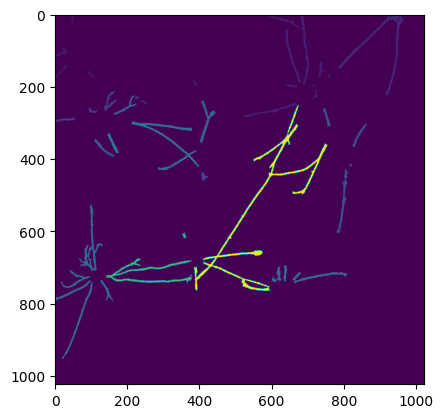

In [288]:
# making stack of protrusions connected to each cell body
labs_cell_bodies = skimage.measure.label(cell_bodies)
#labs_protrusions = skimage.measure.label(protrusions)

protrusions_attached_to_singlecells_stack = np.zeros((labs_cell_bodies.shape[0],labs_cell_bodies.shape[1],labs_cell_bodies.max()))
for index_cell in np.arange(1,labs_cell_bodies.max()):
    onecell_image = np.zeros_like(cell_bodies)
    onecell_image[labs_cell_bodies==index_cell] = 1

    protrusions_attached_to_singlecells_stack[:,:,index_cell-1] = regionswithoverlap(protrusions, onecell_image)*index_cell

plt.imshow(protrusions_attached_to_singlecells_stack.sum(axis=2))


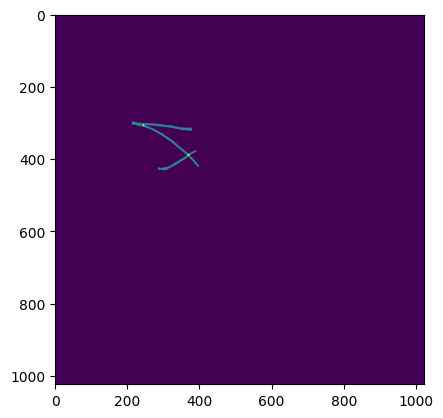

In [297]:
connections = (protrusions_attached_to_singlecells_stack>0).sum(axis=2)
connections = connections>1
labs_connections = skimage.measure.label(connections)
connection_segment = labs_connections==6 # next code cell same but with for loop

connection_segment_stack = protrusions_attached_to_singlecells_stack[connection_segment,:]
labs_cells_connected = np.unique(connection_segment_stack)
labs_cells_connected[labs_cells_connected>0]

crossing_points = np.logical_and(crossing_points_all,connection_segment)
# for each junction 

a = connection_segment+(crossing_points*3)
plt.imshow(a,vmin=0,vmax=2)

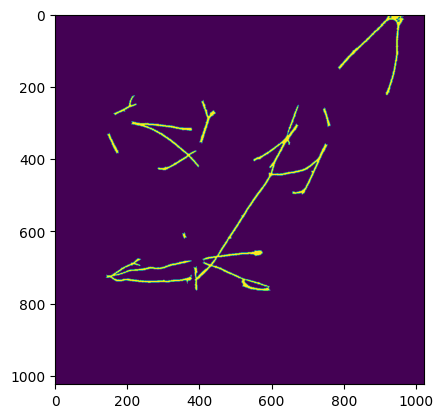

In [256]:
connections = (protrusions_attached_to_singlecells_stack>0).sum(axis=2)
connections = connections>1
labs_connections = skimage.measure.label(connections)

for ind_connection in np.arange(1,labs_connections.max()):
    connection_segment = labs_connections==ind_connection
    connection_segment_stack = protrusions_attached_to_singlecells_stack[connection_segment,:]
    labs_cells_connected = np.unique(connection_segment_stack)
    labs_cells_connected[labs_cells_connected>0]

plt.imshow(connections)